In [1]:
import pandas as pd
import numpy as np
from pylab import mpl, plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

In [3]:
from os import listdir
from os.path import isfile, join

path = "../data generators/generated_wiki_pageview_data/"
files = [f for f in listdir(path) if isfile(join(path, f))]

In [4]:
files = [f for f in files if f[-3:] == 'csv']
files

['Litecoin_daily.csv',
 'Ethereum_daily.csv',
 'Cardano_daily.csv',
 'Bitcoin_daily.csv',
 'EOS.IO_daily.csv',
 'Bitcoin_Cash_daily.csv',
 'Tether_(cryptocurrency)_daily.csv',
 'Chainlink_daily.csv',
 'Ripple_(payment_protocol)_daily.csv',
 'TRON_(cryptocurrency)_daily.csv']

In [5]:
path = "../data generators/generated_price_data/"
files2 = [f for f in listdir(path) if isfile(join(path, f))]
files2

['ada-usd_daily.csv',
 'xlm-usd_daily.csv',
 'xrp-usd_daily.csv',
 'trx-usd_daily.csv',
 'xmr-usd_daily.csv',
 'neo-usd_daily.csv',
 'eth-usd_daily.csv',
 'xtz-usd_daily.csv',
 'atom-us_daily.csv',
 'zec-usd_daily.csv',
 'ltc-usd_daily.csv',
 'link-us_daily.csv',
 'btc-usd_daily.csv',
 'etc-usd_daily.csv',
 'bch-usd_daily.csv',
 'eos-usd_daily.csv']

In [6]:
article_crypto = {"Litecoin":"ltc",
                  "Ethereum":"eth",
                  "Cardano":"ada",
                  "Bitcoin":"btc",
                  "Bitcoin_Cash":"bch",
                  "Chainlink":"link",
                  "Ripple":"xrp",
                  "TRON":"trx"}

## Momentum with SMA Strategy

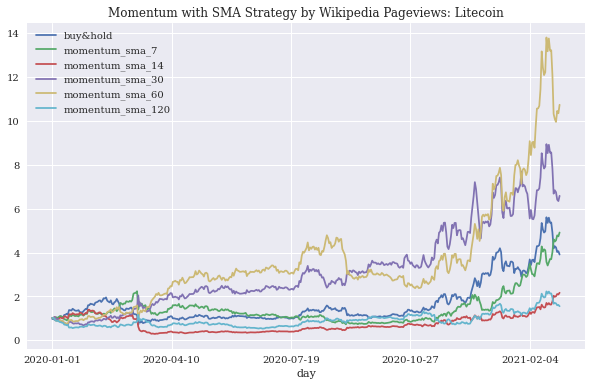

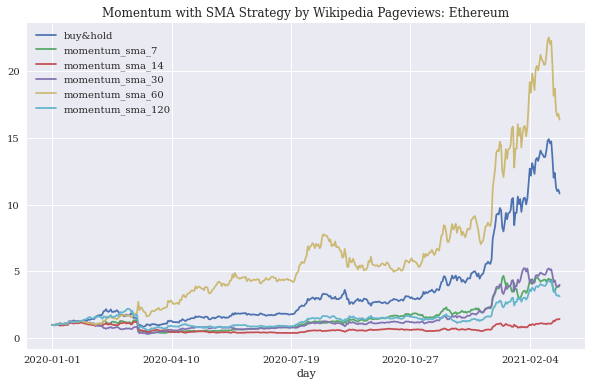

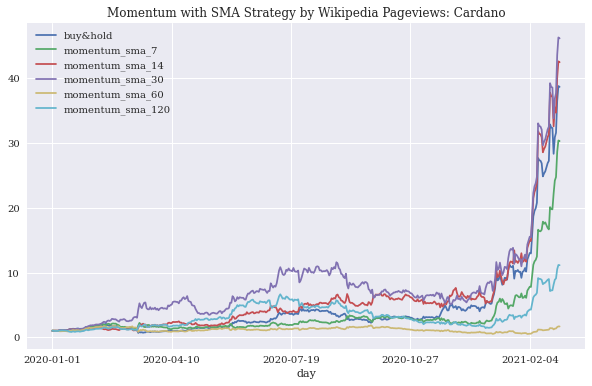

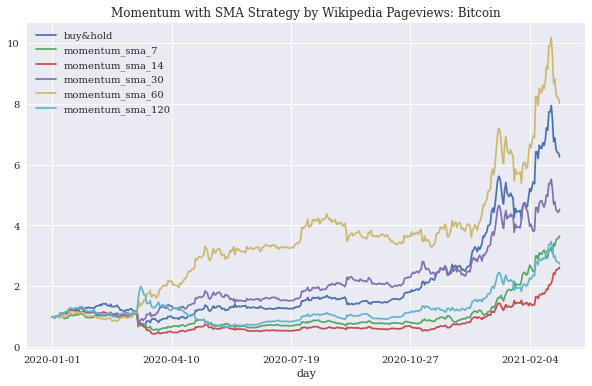

In [11]:
for c in list(article_crypto.keys()):
    try:
        #read file
        price_data_file = [f for f in files2 if f.split('-')[0] == article_crypto[c]][0]
        data = pd.read_csv("../data generators/generated_price_data/"+price_data_file)
        data = data[['market','day','close']]
        data.index = data['day']

        pageview_data_file = [f for f in files if f.split('_')[0] == c][0]
        pageview = pd.read_csv("../data generators/generated_wiki_pageview_data/"+pageview_data_file)
        pageview = pageview[['article','day','pageview']]
        pageview.index = pageview['day']

        #take proportion of the data
        test_data = data[(data['day'] >= '2019-12-31')]
        #find buy&hold strategy returns
        test_data['returns'] = (test_data['close'] / test_data['close'].shift(1))-1
        test_data.dropna(inplace=True)
        test_data['buy&hold'] = (1+test_data['returns'].values).cumprod()

        returns_data = test_data[['returns','buy&hold']].copy()

        smas = [7,14,30,60,120]
        for sma in smas:
            test_data = data[(data['day'] >= '2018-01-01')]
            last_day = data['day'].values[-1]
            test_data['pageview'] = pageview[(pageview['day'] >= '2018-01-01') & 
                                             (pageview['day'] <= last_day)]['pageview'].values

            #find sma values
            test_data['sma'+str(sma)] = test_data['pageview'].rolling(sma).mean()
            test_data['sma'+str(sma)+'_shifted'] = test_data['sma'+str(sma)].shift(1)
            #test_data.dropna(inplace=True)

            #determine position
            col_name = 'momentum_sma_'+str(sma)
            test_data[col_name+'_position'] = np.where(test_data['sma'+str(sma)] > test_data['sma'+str(sma)+'_shifted'], 1, -1)

            #find returns
            test_data['returns'] = (test_data['close'] / test_data['close'].shift(1))-1
            test_data[col_name+'_returns'] = test_data[col_name+'_position'].shift(1) * test_data['returns']
            test_data.dropna(inplace=True)

            #find cumulative returns
            test_data = test_data[test_data['day'] >= '2020-01-01']
            returns_data[col_name+'_returns'] = test_data[col_name+'_returns'].values
            returns_data[col_name] = (1+returns_data[col_name+'_returns'].values).cumprod()
        
    except:
        continue
    
    plot_columns = ['buy&hold']+['momentum_sma_'+str(sma) for sma in smas]

    plot_title = "Momentum with SMA Strategy by Wikipedia Pageviews: "+c
    ax = returns_data[plot_columns].plot(title=plot_title,figsize=(10, 6))
    ax.get_legend()

In [30]:
#ax = test_data[['close','sma1','sma2','position']].plot(secondary_y='position',figsize=(10, 6))
#ax.get_legend()